# Модуль 10. **Згорткові нейронні мережі**

In [584]:
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

import keras

from keras.layers import Dense, Dropout
from keras.models import Sequential

from keras import optimizers
from keras import losses
from keras import metrics
import copy

In [585]:
# константи кольору
YELLOW = "\033[33m"
LIGHTBLUE = "\033[94m"
CYAN = "\033[36m"
GRAY_BACK = "\033[100m"
RESET = "\033[0m"

### Завдання
**Частина 1**

В якості домашнього завдання вам пропонується створити нейронну мережу за допомогою механізмів Keras, яка буде класифікувати товари із датасету _fasion_mnist_ (https://www.tensorflow.org/datasets/catalog/fashion_mnist).

На відміну від попереднього завдання вам пропонується створити згорткову нейромережу. Підберіть архітектуру мережі та навчіть її на даних із датасету fasion_mnist. Спробуйте досягти максимально можливої точності класифікації за рахунок маніпуляції параметрами мережі. Порівняйте точність отриманої згорткової мережі з точністю багатошарової мережі з попереднього завдання. Зробіть висновки.

<div class="alert alert-block alert-warning"> В попередньому ДЗ було досягнуто точність <b>90.72%</b><br>
Намагатимемося досягти кращого результату, використовуючи вже відпрацьовану методику</div>

    Завантаження та аналіз даних

In [586]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

In [587]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [588]:
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
    # "Футболка/майка",
    # "Штани",
    # "Світшот",
    # "Сукня",
    # "Пальто",
    # "Сандалі",
    # "Сорочка",
    # "Кросівки",
    # "Сумка",
    # "Ботильйони",
]

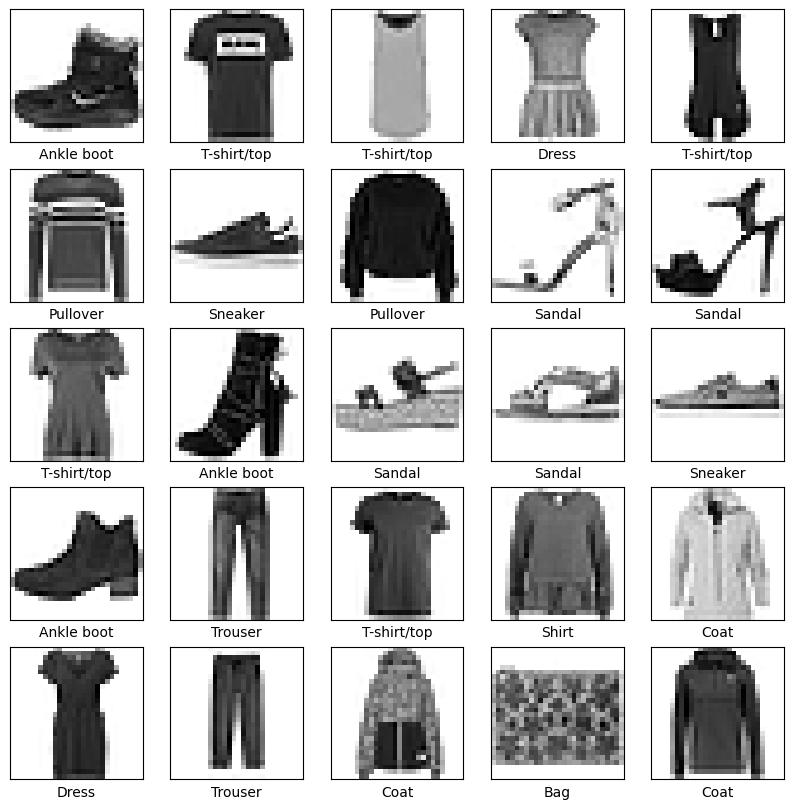

In [589]:
num_to_plot = 25

plt.figure(figsize=(10, 10))

for i in range(num_to_plot):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

plt.show() 

### Допоміжні функції

    Функція друку поточних параметрів
######      Аргументи: <br>1.  parameters - Поточні параметри для тренування моделі<br>2. text - Заголовок списку параметрів

In [590]:
def print_parameters(parameters: dict, text='Поточні параметри:'):
    print(f"{LIGHTBLUE}{text}{RESET}")
    # print("-" * 18)
    for k, val in parameters.items():
        print(f" {k} \t= {YELLOW}{val}{RESET}")

    Функція відображення графіків історії точності та втрат
######      Аргументи: <br>1. history - дані історії точності та втрат<br>2.  parameters - Поточні параметри тренування моделі

In [591]:
def plt_history(history, parameters):

    dict_data = {
        "accuracy": "Точність на тренувальному наборі",
        "val_accuracy": "Точність на тестовому наборі",
        "loss": "Втрати на тренувальному наборі",
        "val_loss": "Втрати на тестовому наборі",
    }
    epochs = range(1, len(history.history["accuracy"]) + 1)

    color_acc = "royalblue"
    color_loss = "peru"
    linestyle_train = "--"
    linestyle_test = "-"

    print_parameters(parameters)

    for data_, label_ in dict_data.items():
        plt.plot(
            epochs,
            history.history[data_],
            color=color_loss if (data_[-4:] == "loss") else color_acc,
            linestyle=linestyle_test if (data_[:3] == "val") else linestyle_train,
            label=label_,
        )

    plt.ylim(0, 1)
    # plt.title("Точність та втрати на тренувальному та тестовому наборах")
    plt.xlabel("Епоха")
    plt.ylabel("Метрика")
    plt.legend()
    plt.show()

    Функція підготовки моделі
######      Аргументи: <br>1. model_func - Функція, що містить модель для тренування<br>2. hidden_units, activation, dropout_rate, optimizer, loss_function, metrics - Параметри для створення моделі<br>3. summary - Параметр для керування виводом даних моделі

In [592]:
def prepare_model(
    model_func,
    hidden_units,
    activation,
    dropout_rate,
    optimizer,
    loss_function,
    metrics,
    summary,
):
    model = model_func(hidden_units, activation, dropout_rate)

    model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

    if summary:
        model.summary()

    return model

    Функція тренування моделі
######      Аргументи: <br>1.  train_images, train_labels, test_images, test_labels - Набори даних для навчання і валідації<br>2. model_func - Функція, що містить модель для тренування<br>3. hidden_units, activation, dropout_rate, optimizer, loss_function, metrics - Параметри для створення моделі<br>4. epochs, batch_size - Параметри для тренування моделі<br>4. verbose, summary - Параметри для керування виводом даних навчання моделі

In [593]:
def train_model(
    train_images,
    train_labels,
    test_images,
    test_labels,
    model_func,
    epochs,
    batch_size,
    dropout_rate,
    loss_function,
    optimizer,
    hidden_units,
    activation,
    metrics,
    verbose=0,
    summary=0,
):

    early_stopping = EarlyStopping(
        monitor="val_accuracy", patience=5, restore_best_weights=True
    )

    reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.4, patience=5, min_lr=1e-8
    )

    model = prepare_model(
        model_func,
        hidden_units,
        activation,
        dropout_rate,
        optimizer,
        loss_function,
        metrics,
        summary,
    )

    history = model.fit(
        train_images,
        train_labels,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(test_images, test_labels),
        callbacks=[reduce_lr_callback, early_stopping],
        verbose=verbose,
    )

    print("          Точність:")
    train_loss, train_acc = model.evaluate(train_images, train_labels)
    print("          тренувальні дані: ", YELLOW, train_acc, RESET)

    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print("          тестові дані:     ", YELLOW, test_acc, RESET)

    return history, test_acc

      Функція пошуку оптимальних параметрів

######      Аргументи: <br>1.  train_images, train_labels, test_images, test_labels - Набори даних для навчання і валідації<br>2.  parameters - Параметри для тренування моделі<br>3.  optimal_parameters - Оптимальні параметри. Спочатку "зі стелі", під час аналізу змінюються на оптимальні<br>4.  study_sequence - Послідовність параметрів, що мають перевірятися<br>5. model_func - Функція, що містить модель для тренування

In [594]:
def find_optimal_parameters(
    parameters,
    study_sequence,
    optimal_parameters,
    model_func,
    train_images=train_images,
    train_labels=train_labels,
    test_images=test_images,
    test_labels=test_labels,
    verbose=0,
    summary=0,
):

    best_accuracy = 0.0
    best_parameters = {}

    for param in study_sequence:

        print(f"{GRAY_BACK}{"=" * 50}{RESET}")
        print(f"Пошук оптимального значення параметра: {YELLOW}{param} {RESET}")
        print(f"{GRAY_BACK}{"=" * 50}{RESET}")

        param_values = parameters[param]
        best_value = optimal_parameters[param]

        for value in param_values:
            optimal_parameters[param] = value

            print("-" * 50)
            print(f"Тестується значення: {YELLOW}{param} = {value}{RESET}")
            print("-" * 50)

            history, test_acc = train_model(
                train_images,
                train_labels,
                test_images,
                test_labels,
                model_func,
                verbose=verbose,
                summary=summary,
                **optimal_parameters,
            )

            if test_acc > best_accuracy:
                best_accuracy = test_acc
                best_parameters = copy.deepcopy(optimal_parameters)
                best_value = value

            # Plotting training history
            plt_history(history, optimal_parameters)

        # Update optimal parameter for the current parameter
        optimal_parameters[param] = best_value

        print(
            f"{LIGHTBLUE} Оптимальне значення параметра {YELLOW}{param} = {best_value}"
        )
        print(f"{LIGHTBLUE}   точність на тестових даних: {YELLOW}{best_accuracy}{RESET}", end='\n\n')

    return best_parameters, best_accuracy

    Параметри для тренування моделей

In [595]:
# Оптимальні параметри.
# Спочатку "зі стелі", під час навчання змінюються на справді оптимальні.
optimal_parameters = {
    "epochs": 10,
    "batch_size": 32,
    "dropout_rate": 0.2,
    "loss_function": "sparse_categorical_crossentropy",
    "optimizer": "adam",
    "hidden_units": 32,
    "activation": "relu",
    "metrics": ["accuracy"],
}

# Списки параметрів, що мають бути досліджені
parameters = {
    "epochs": [5, 10, 15, 20],
    # "epochs": [10, 20, 50, 100],

    # "batch_size": [128, 256],
    # "batch_size": [8, 16, 32, 64, 128, 256],
    "batch_size": [8, 16, 32, 64],

    # "dropout_rate": [0.1, 0.2],
    "dropout_rate": [0.0, 0.1, 0.2, 0.3],

    "loss_function": [
        "sparse_categorical_crossentropy",
        # "binary_crossentropy",
        # "mean_squared_error",
    ],

    "optimizer": ["adam", "sgd", "rmsprop"],
    # "optimizer": ["adam", "rmsprop", "sgd", "adagrad", "adadelta"],

    # "hidden_units": [64, 128, 256, 512],
    "hidden_units": [16, 32, 64, 128],

    "activation": ["relu", "sigmoid"],
    # "activation": ["relu", "sigmoid", "tanh"],

    "metrics": ["accuracy",],
}

***
### **Модель для тренування 1** 
***
     Шари: 
1. **Conv2D** (32, (3, 3), input_shape=(28, 28, 1))

2. **MaxPooling2D** ((2, 2))

3. **Conv2D** (64, (3, 3))

4. **MaxPooling2D** ((2, 2))

5. **Flatten**

6. **Dense** 

7. **Dense** (10)

In [596]:
def model_CNN_1(hidden_units, activation, dropout_rate):

    model = models.Sequential(
        [
            layers.Conv2D(32, (3, 3), activation=activation, input_shape=(28, 28, 1)),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation=activation),
            layers.MaxPooling2D((2, 2)),
            # layers.Conv2D(64, (3, 3), activation=activation),
            layers.Flatten(),
            # layers.Dropout(dropout_rate),
            layers.Dense(hidden_units, activation=activation),
            layers.Dense(10, activation="softmax"),
        ]
    )
    return model

    Параметри, для навчання моделі 1
###### study_sequence - Послідовність дослідження

In [597]:
study_sequence = [
    "optimizer",
    "activation",
    "hidden_units",
    # "dropout_rate",
    "batch_size",
    "epochs",
    # # "loss_function",
    # # # "metrics",
]

Пошук оптимальних параметрів для моделі  **model_CNN_1**

Пошук оптимального значення параметра: optimizer 
--------------------------------------------------
Тестується значення: optimizer = adam
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9415 - loss: 0.1627
          тренувальні дані:   0.9397666454315186 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9075 - loss: 0.2785
          тестові дані:       0.9083999991416931 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']


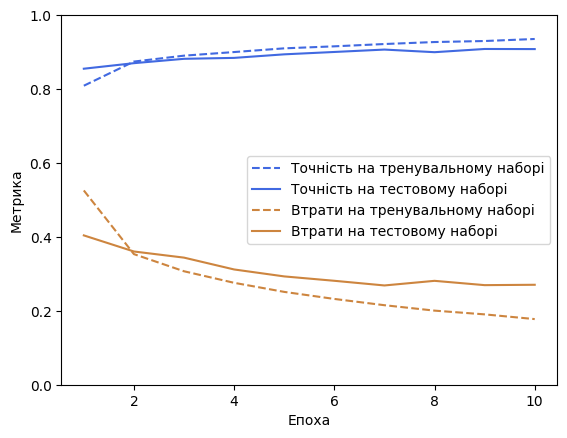

--------------------------------------------------
Тестується значення: optimizer = sgd
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8894 - loss: 0.3098
          тренувальні дані:   0.888700008392334 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8762 - loss: 0.3473
          тестові дані:       0.8752999901771545 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= sgd
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']


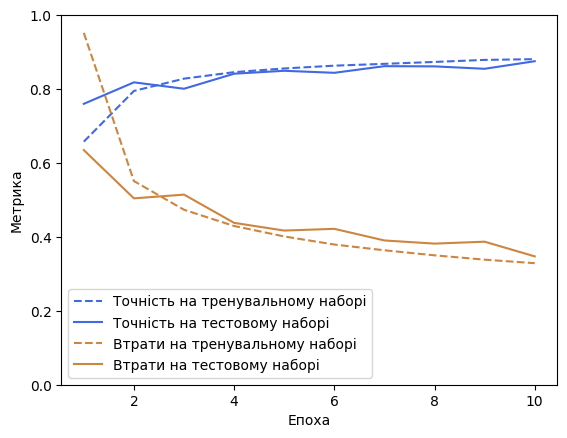

--------------------------------------------------
Тестується значення: optimizer = rmsprop
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9488 - loss: 0.1418
          тренувальні дані:   0.9477166533470154 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9045 - loss: 0.2986
          тестові дані:       0.9060999751091003 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']


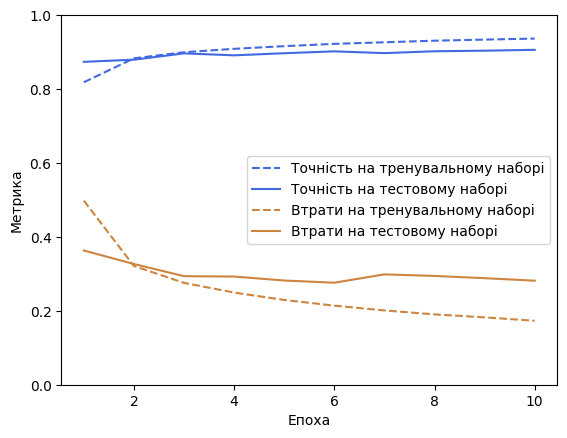

 Оптимальне значення параметра optimizer = adam
   точність на тестових даних: 0.9083999991416931

Пошук оптимального значення параметра: activation 
--------------------------------------------------
Тестується значення: activation = relu
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9501 - loss: 0.1343
          тренувальні дані:   0.9499666690826416 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9048 - loss: 0.2853
          тестові дані:       0.9077000021934509 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']


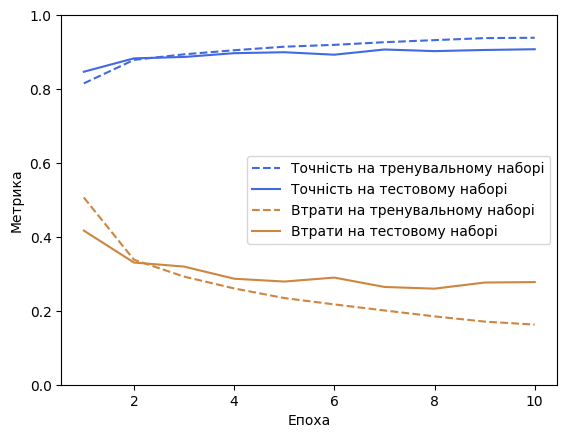

--------------------------------------------------
Тестується значення: activation = sigmoid
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9017 - loss: 0.2649
          тренувальні дані:   0.9013166427612305 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8786 - loss: 0.3243
          тестові дані:       0.8823000192642212 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 32
 activation 	= sigmoid
 metrics 	= ['accuracy']


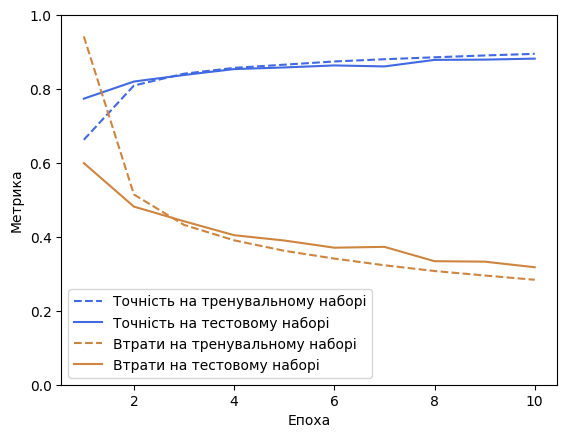

 Оптимальне значення параметра activation = relu
   точність на тестових даних: 0.9083999991416931

Пошук оптимального значення параметра: hidden_units 
--------------------------------------------------
Тестується значення: hidden_units = 16
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9224 - loss: 0.2122
          тренувальні дані:   0.9227666854858398 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9017 - loss: 0.2778
          тестові дані:       0.9027000069618225 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 16
 activation 	= relu
 metrics 	= ['accuracy']


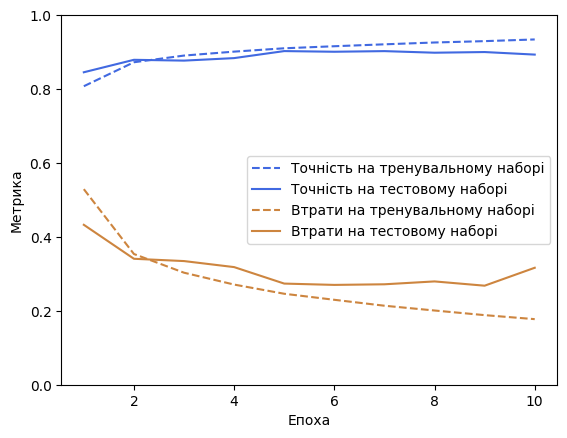

--------------------------------------------------
Тестується значення: hidden_units = 32
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9461 - loss: 0.1481
          тренувальні дані:   0.9444500207901001 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9101 - loss: 0.2785
          тестові дані:       0.9100000262260437 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']


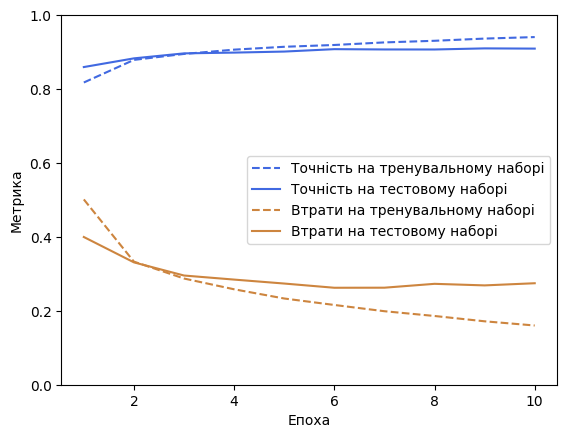

--------------------------------------------------
Тестується значення: hidden_units = 64
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9400 - loss: 0.1661
          тренувальні дані:   0.9383166432380676 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9096 - loss: 0.2561
          тестові дані:       0.9072999954223633 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']


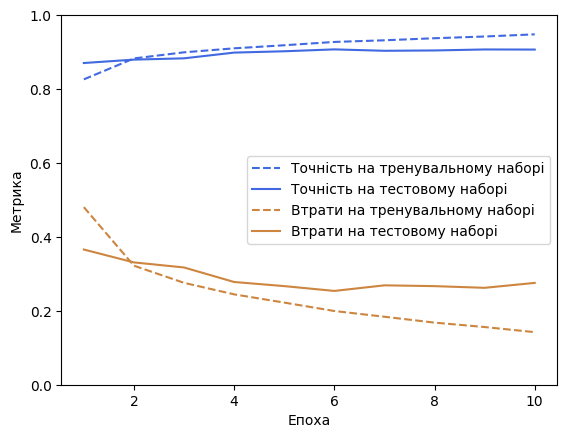

--------------------------------------------------
Тестується значення: hidden_units = 128
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9572 - loss: 0.1165
          тренувальні дані:   0.9558833241462708 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9123 - loss: 0.2650
          тестові дані:       0.9135000109672546 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


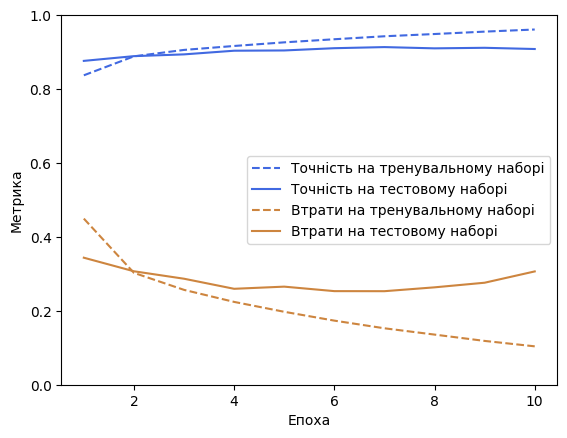

 Оптимальне значення параметра hidden_units = 128
   точність на тестових даних: 0.9135000109672546

Пошук оптимального значення параметра: batch_size 
--------------------------------------------------
Тестується значення: batch_size = 8
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9865 - loss: 0.0390
          тренувальні дані:   0.9862499833106995 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9125 - loss: 0.3863
          тестові дані:       0.9154000282287598 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 8
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


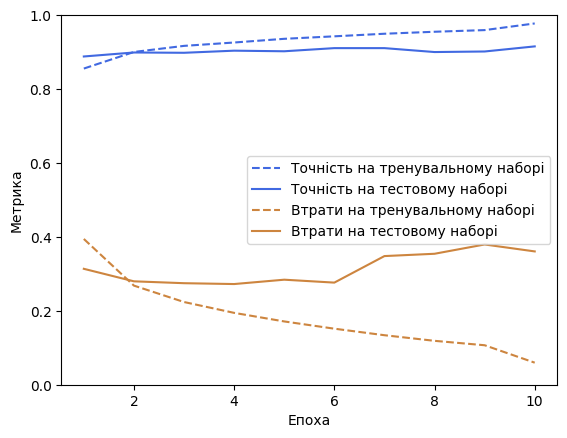

--------------------------------------------------
Тестується значення: batch_size = 16
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9840 - loss: 0.0482
          тренувальні дані:   0.9833333492279053 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9125 - loss: 0.3338
          тестові дані:       0.9125000238418579 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


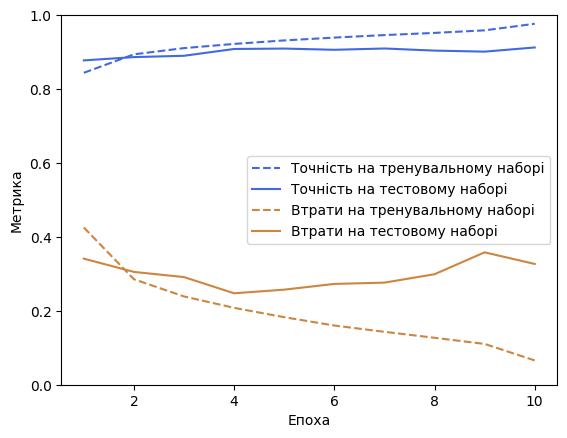

--------------------------------------------------
Тестується значення: batch_size = 32
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9564 - loss: 0.1217
          тренувальні дані:   0.9544000029563904 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9131 - loss: 0.2662
          тестові дані:       0.9136000275611877 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


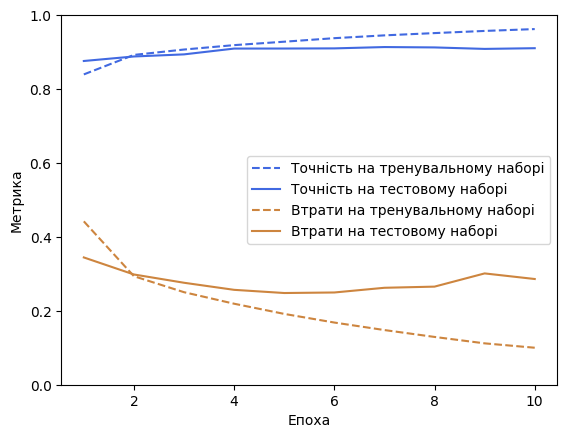

--------------------------------------------------
Тестується значення: batch_size = 64
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9604 - loss: 0.1125
          тренувальні дані:   0.9589833617210388 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9166 - loss: 0.2589
          тестові дані:       0.9154000282287598 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


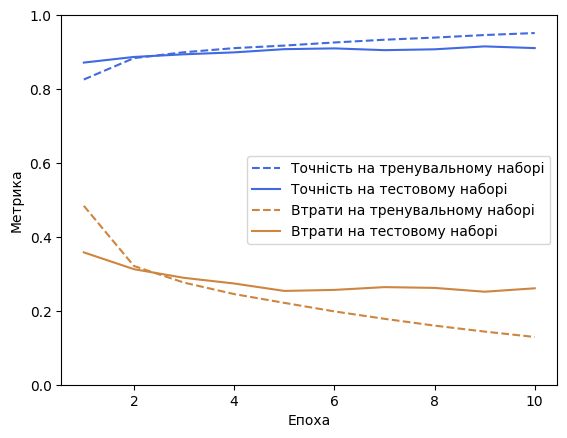

 Оптимальне значення параметра batch_size = 8
   точність на тестових даних: 0.9154000282287598

Пошук оптимального значення параметра: epochs 
--------------------------------------------------
Тестується значення: epochs = 5
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9371 - loss: 0.1677
          тренувальні дані:   0.9358999729156494 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9064 - loss: 0.2720
          тестові дані:       0.9053000211715698 
Поточні параметри:
 epochs 	= 5
 batch_size 	= 8
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


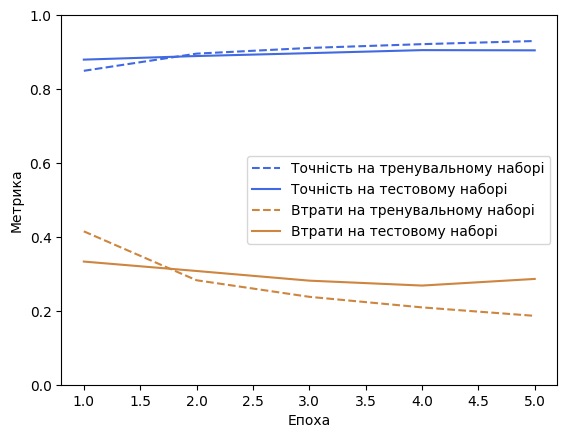

--------------------------------------------------
Тестується значення: epochs = 10
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9657 - loss: 0.0895
          тренувальні дані:   0.9651666879653931 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9017 - loss: 0.4297
          тестові дані:       0.9072999954223633 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 8
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


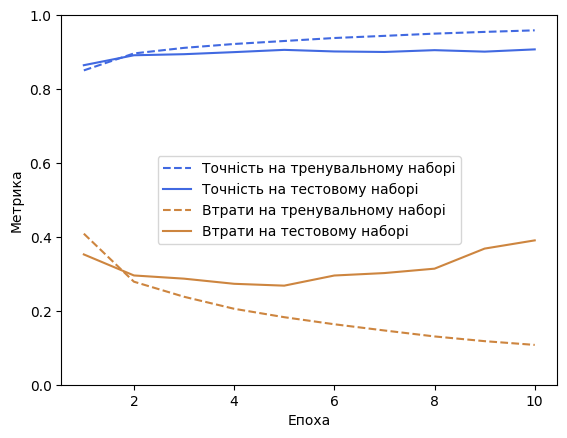

--------------------------------------------------
Тестується значення: epochs = 15
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9850 - loss: 0.0433
          тренувальні дані:   0.9844499826431274 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9153 - loss: 0.3761
          тестові дані:       0.9171000123023987 
Поточні параметри:
 epochs 	= 15
 batch_size 	= 8
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


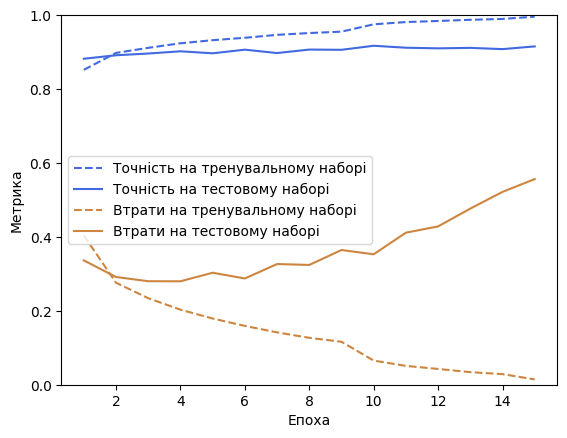

--------------------------------------------------
Тестується значення: epochs = 20
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.9988 - loss: 0.0074
          тренувальні дані:   0.998533308506012 
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9147 - loss: 0.5585
          тестові дані:       0.9192000031471252 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 8
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


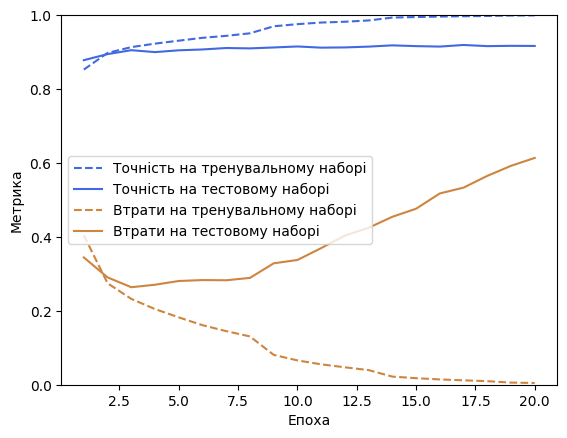

 Оптимальне значення параметра epochs = 20
   точність на тестових даних: 0.9192000031471252



In [598]:
best_parameters, best_accuracy = find_optimal_parameters(
    parameters,
    study_sequence,
    optimal_parameters,
    model_func=model_CNN_1,
    # summary=1,
)

In [599]:
print_parameters(best_parameters, "Оптимальні параметри для model_CNN_1")
print(f" Точність:        {YELLOW}{best_accuracy}")

Оптимальні параметри для model_CNN_1
 epochs 	= 20
 batch_size 	= 8
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']
 Точність:        0.9192000031471252


<div class="alert alert-block alert-info">
<b>Висновки model_1:</b> 
<p>Отримано оптимальні параметри для базової моделі з одним прихованим шаром<br>Навіть за оптимізованих параметрів точність моделі (<b>89.68%</b>) недостатня</p>
</div>

***
### **Модель для тренування 2** 
***
_Ускладнимо модель, додавши два додаткових шари: **Conv2D** та **Dropout**_


_також скоротимо перелік параметрів, що досліджуються до трьох_
1. 'dropout_rate',
2. 'hidden_units',
3. 'epochs'

In [600]:
def model_CNN_2(hidden_units, activation, dropout_rate):

    model = models.Sequential(
        [
            layers.Conv2D(32, (3, 3), activation=activation, input_shape=(28, 28, 1)),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation=activation),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation=activation),  # added in model_2
            layers.Flatten(),
            layers.Dropout(dropout_rate),  # added in model_2
            layers.Dense(hidden_units, activation=activation),
            layers.Dense(10, activation="softmax"),
        ]
    )
    return model

     Оптимальні параметри, що було визначено під час дослідження 

In [601]:
print_parameters(best_parameters, "Оптимальні параметри для model_CNN_1")

Оптимальні параметри для model_CNN_1
 epochs 	= 20
 batch_size 	= 8
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


In [602]:
study_sequence = [
    "batch_size",
    "dropout_rate",
    "hidden_units",
    # "loss_function",
    "optimizer",
    "activation",
    # # "metrics",
    "epochs",
]

Пошук оптимального значення параметра: batch_size 
--------------------------------------------------
Тестується значення: batch_size = 8
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9619 - loss: 0.1038
          тренувальні дані:   0.9612166881561279 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9153 - loss: 0.2723
          тестові дані:       0.9153000116348267 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 8
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


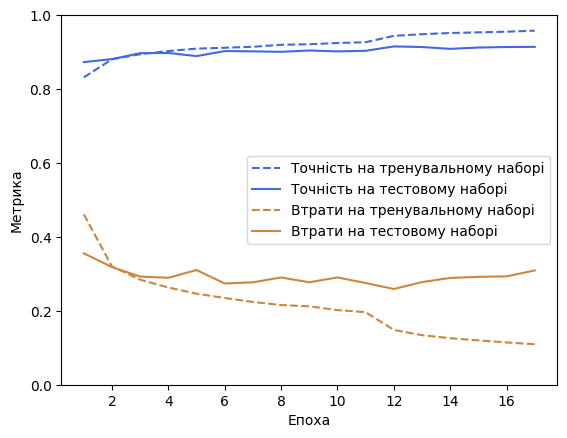

--------------------------------------------------
Тестується значення: batch_size = 16
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9514 - loss: 0.1323
          тренувальні дані:   0.9506333470344543 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9117 - loss: 0.2501
          тестові дані:       0.9118000268936157 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 16
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


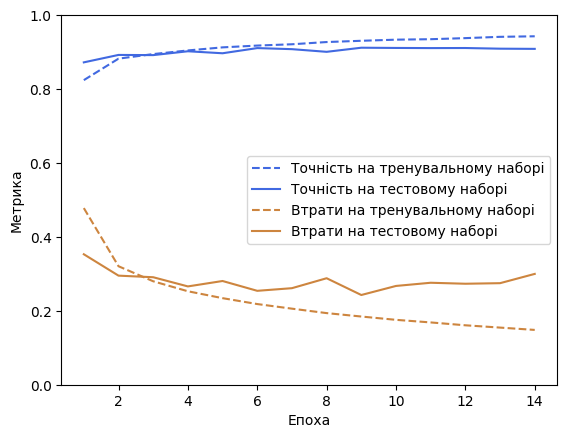

--------------------------------------------------
Тестується значення: batch_size = 32
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9867 - loss: 0.0407
          тренувальні дані:   0.98621666431427 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9179 - loss: 0.3213
          тестові дані:       0.9186000227928162 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


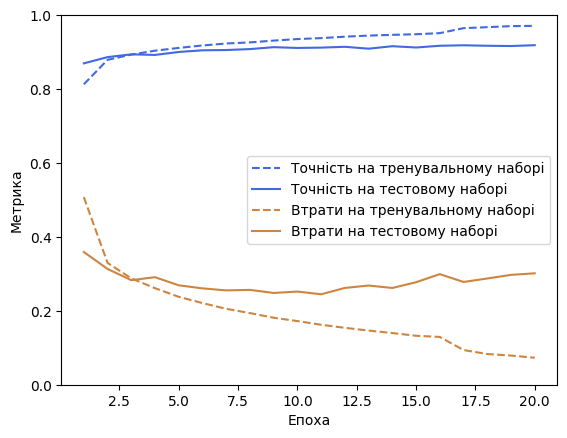

--------------------------------------------------
Тестується значення: batch_size = 64
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9807 - loss: 0.0548
          тренувальні дані:   0.9805833101272583 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9204 - loss: 0.2828
          тестові дані:       0.9229000210762024 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


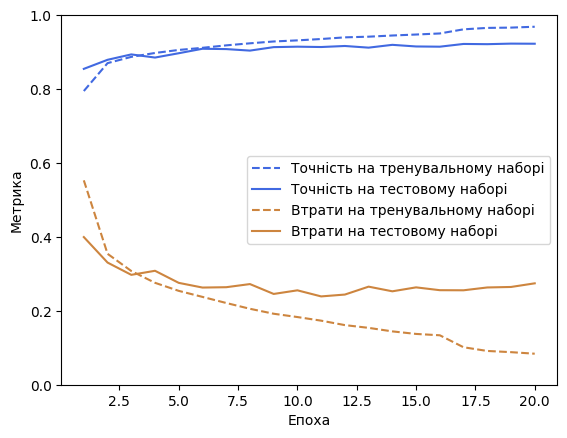

 Оптимальне значення параметра batch_size = 64
   точність на тестових даних: 0.9229000210762024

Пошук оптимального значення параметра: dropout_rate 
--------------------------------------------------
Тестується значення: dropout_rate = 0.0
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9943 - loss: 0.0225
          тренувальні дані:   0.9940666556358337 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9219 - loss: 0.3942
          тестові дані:       0.9222999811172485 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 64
 dropout_rate 	= 0.0
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


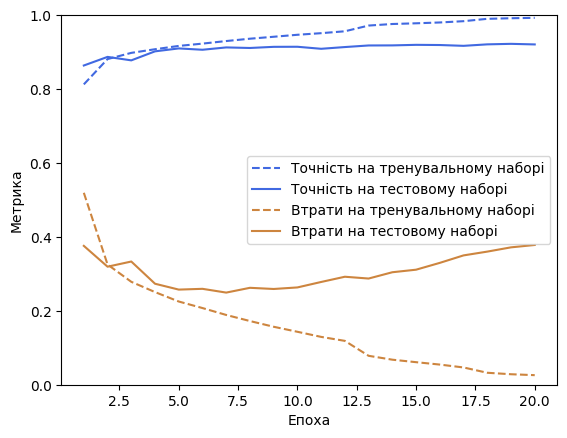

--------------------------------------------------
Тестується значення: dropout_rate = 0.1
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9842 - loss: 0.0489
          тренувальні дані:   0.9836333394050598 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9223 - loss: 0.2722
          тестові дані:       0.9232000112533569 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 64
 dropout_rate 	= 0.1
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


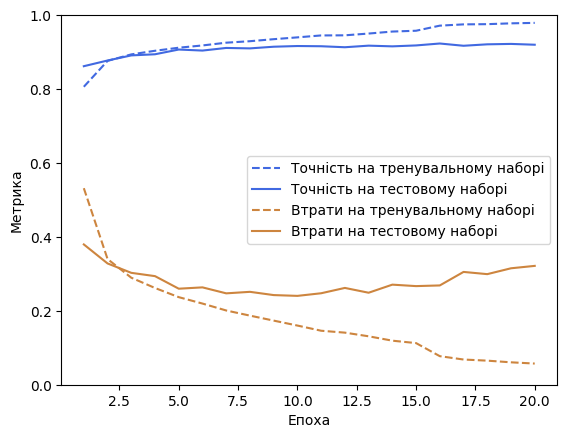

--------------------------------------------------
Тестується значення: dropout_rate = 0.2
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9789 - loss: 0.0625
          тренувальні дані:   0.9785666465759277 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9219 - loss: 0.2631
          тестові дані:       0.9240000247955322 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


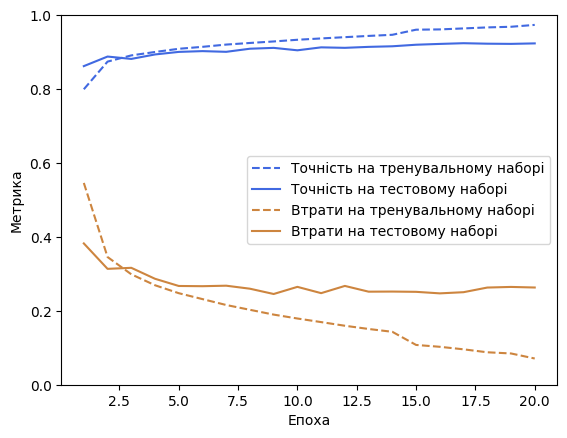

--------------------------------------------------
Тестується значення: dropout_rate = 0.3
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.9722 - loss: 0.0768
          тренувальні дані:   0.971666693687439 
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9160 - loss: 0.2688
          тестові дані:       0.9193000197410583 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 64
 dropout_rate 	= 0.3
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


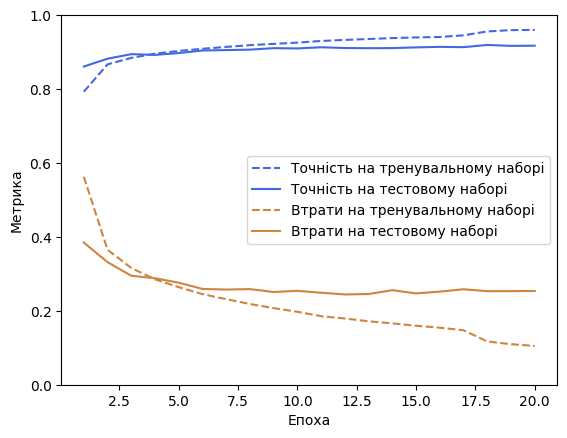

 Оптимальне значення параметра dropout_rate = 0.2
   точність на тестових даних: 0.9240000247955322

Пошук оптимального значення параметра: hidden_units 
--------------------------------------------------
Тестується значення: hidden_units = 16
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.9732 - loss: 0.0815
          тренувальні дані:   0.9717000126838684 
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9167 - loss: 0.2575
          тестові дані:       0.9185000061988831 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 16
 activation 	= relu
 metrics 	= ['accuracy']


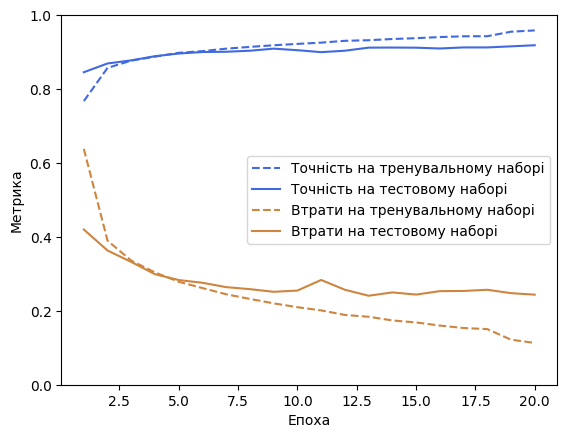

--------------------------------------------------
Тестується значення: hidden_units = 32
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.9689 - loss: 0.0866
          тренувальні дані:   0.9691166877746582 
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9202 - loss: 0.2476
          тестові дані:       0.9215999841690063 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 32
 activation 	= relu
 metrics 	= ['accuracy']


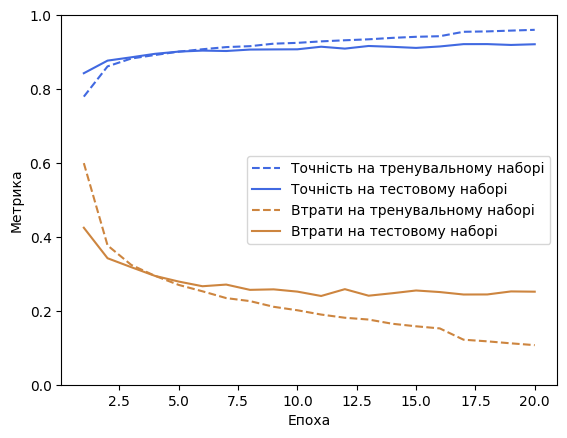

--------------------------------------------------
Тестується значення: hidden_units = 64
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - accuracy: 0.9498 - loss: 0.1403
          тренувальні дані:   0.9488666653633118 
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9129 - loss: 0.2497
          тестові дані:       0.9161999821662903 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']


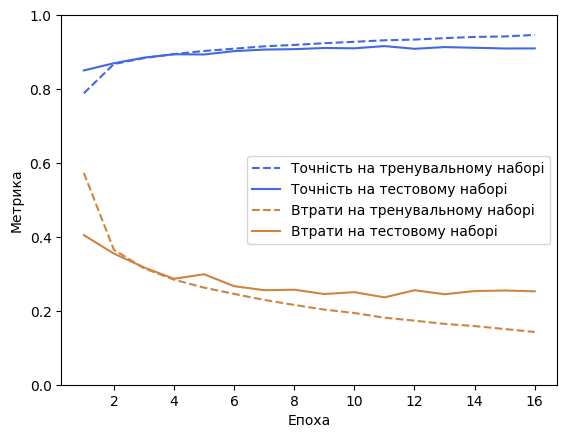

--------------------------------------------------
Тестується значення: hidden_units = 128
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9792 - loss: 0.0599
          тренувальні дані:   0.9786166548728943 
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9211 - loss: 0.2781
          тестові дані:       0.9244999885559082 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


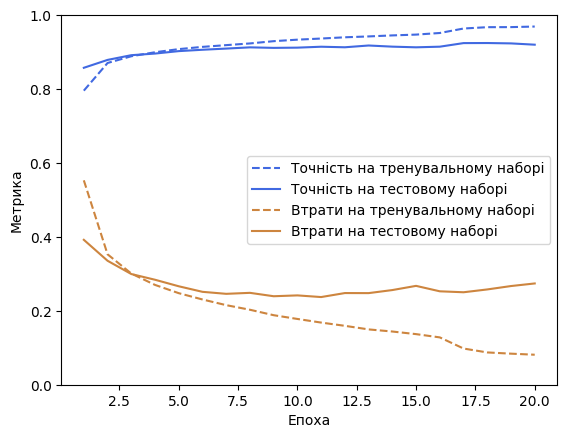

 Оптимальне значення параметра hidden_units = 128
   точність на тестових даних: 0.9244999885559082

Пошук оптимального значення параметра: optimizer 
--------------------------------------------------
Тестується значення: optimizer = adam
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9822 - loss: 0.0552
          тренувальні дані:   0.9807166457176208 
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9218 - loss: 0.2768
          тестові дані:       0.9229000210762024 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


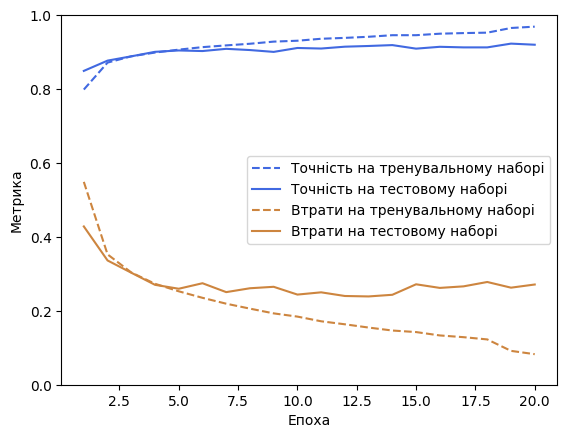

--------------------------------------------------
Тестується значення: optimizer = sgd
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8931 - loss: 0.2915
          тренувальні дані:   0.8916500210762024 
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8815 - loss: 0.3313
          тестові дані:       0.8794000148773193 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= sgd
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


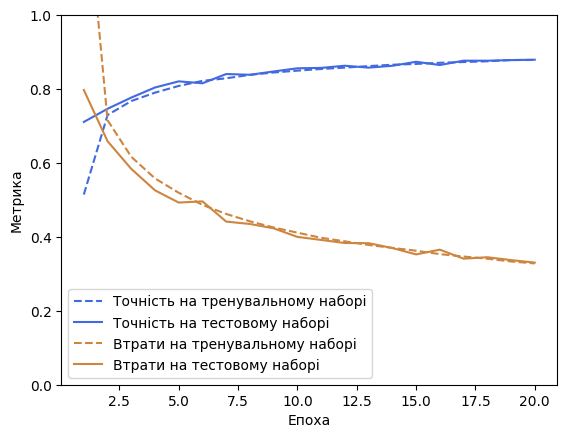

--------------------------------------------------
Тестується значення: optimizer = rmsprop
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9788 - loss: 0.0649
          тренувальні дані:   0.9780333042144775 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9182 - loss: 0.2709
          тестові дані:       0.9204000234603882 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


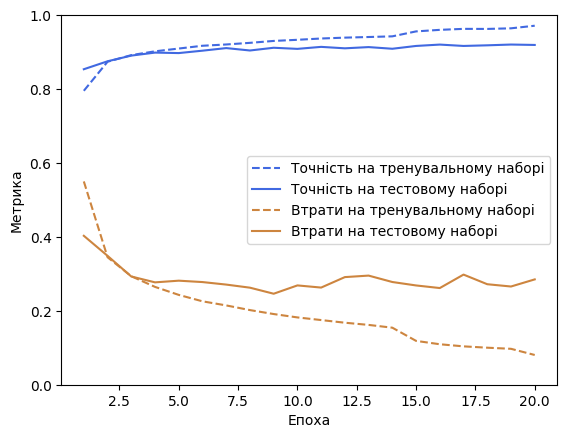

 Оптимальне значення параметра optimizer = adam
   точність на тестових даних: 0.9244999885559082

Пошук оптимального значення параметра: activation 
--------------------------------------------------
Тестується значення: activation = relu
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9561 - loss: 0.1216
          тренувальні дані:   0.9544666409492493 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9194 - loss: 0.2358
          тестові дані:       0.9180999994277954 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


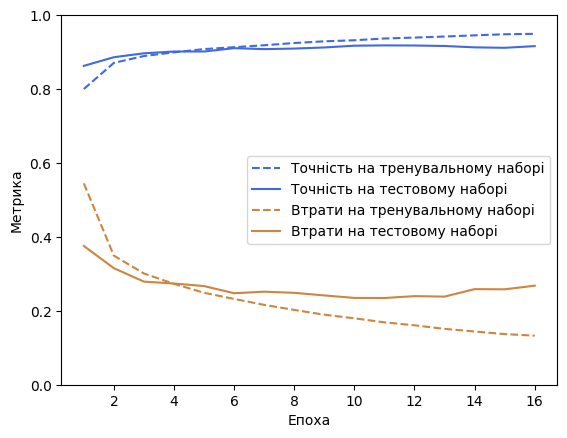

--------------------------------------------------
Тестується значення: activation = sigmoid
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9187 - loss: 0.2130
          тренувальні дані:   0.918483316898346 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9003 - loss: 0.2840
          тестові дані:       0.8981000185012817 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= sigmoid
 metrics 	= ['accuracy']


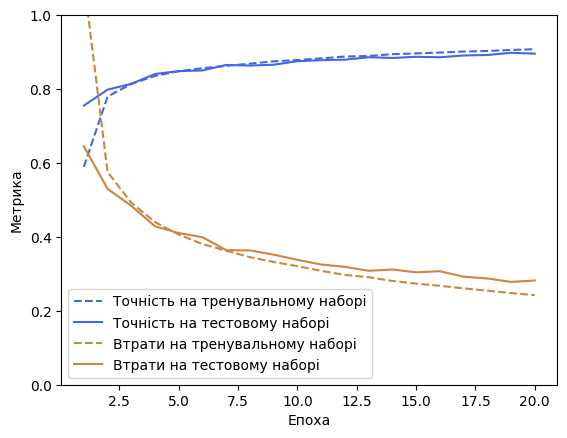

 Оптимальне значення параметра activation = relu
   точність на тестових даних: 0.9244999885559082

Пошук оптимального значення параметра: epochs 
--------------------------------------------------
Тестується значення: epochs = 5
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9244 - loss: 0.2138
          тренувальні дані:   0.9233333468437195 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9043 - loss: 0.2667
          тестові дані:       0.9031999707221985 
Поточні параметри:
 epochs 	= 5
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


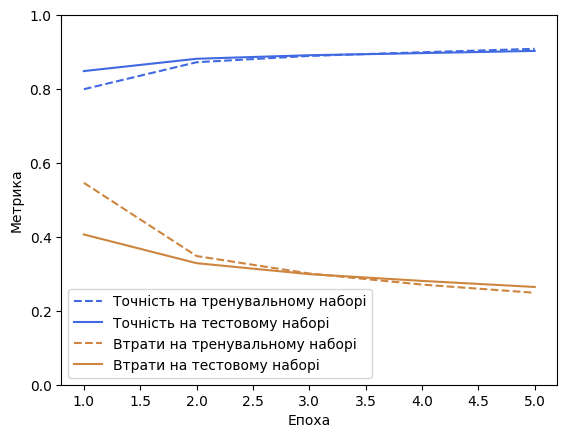

--------------------------------------------------
Тестується значення: epochs = 10
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9372 - loss: 0.1709
          тренувальні дані:   0.9366666674613953 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9089 - loss: 0.2545
          тестові дані:       0.911300003528595 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


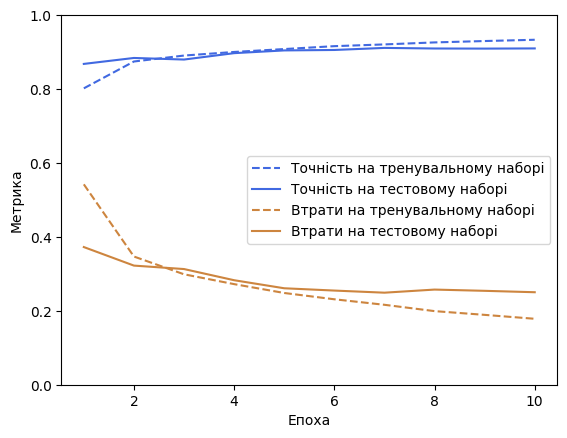

--------------------------------------------------
Тестується значення: epochs = 15
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9723 - loss: 0.0780
          тренувальні дані:   0.9710166454315186 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9214 - loss: 0.2540
          тестові дані:       0.9225999712944031 
Поточні параметри:
 epochs 	= 15
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


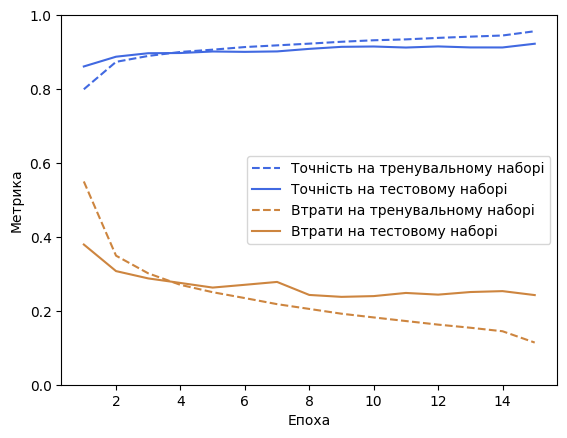

--------------------------------------------------
Тестується значення: epochs = 20
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9838 - loss: 0.0497
          тренувальні дані:   0.9830999970436096 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9190 - loss: 0.2817
          тестові дані:       0.9225000143051147 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


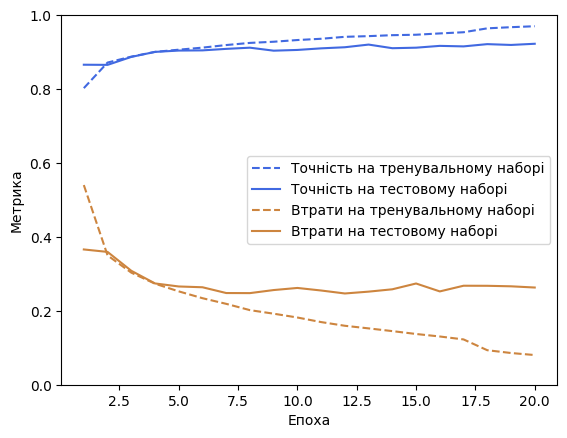

 Оптимальне значення параметра epochs = 20
   точність на тестових даних: 0.9244999885559082



In [603]:
best_parameters, best_accuracy = find_optimal_parameters(
    parameters,
    study_sequence,
    optimal_parameters,
    model_func=model_CNN_2,
)

In [604]:
print_parameters(best_parameters, "Оптимальні параметри для model_2")
print(f" Точність:        {YELLOW}{best_accuracy}")

Оптимальні параметри для model_2
 epochs 	= 20
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']
 Точність:        0.9244999885559082


<div class="alert alert-block alert-info">
<b>Висновки model_2:</b> 
<p>Отримано оптимальні параметри для ускладненої моделі з трьома прихованими шарами<br>Спостерігається <b>невеличке покращення</b> роботи моделі після її ускладнення<br>
<b>Точність</b> на тестових даних змінилася з <b>89.68%</b> до <b>90.27%</b></p>
<p>Оптимальні параметри змінилися тільки в одному пункті: <br>
 - hidden_units було 256 стало 512</p>
</div>

***
### **Модель для тренування 2.1** 
***
_Додамо callback_

     Модель model_CNN_2_1 повністю ідентична моделі model_CNN_2 ( + callback)

     Оптимальні параметри, що було визначено під час попереднього дослідження 

In [605]:
print_parameters(best_parameters, "Оптимальні параметри за результатами дослідження")

Оптимальні параметри за результатами дослідження
 epochs 	= 20
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


In [606]:
epochs = best_parameters["epochs"]
batch_size = best_parameters["batch_size"]
dropout_rate = best_parameters["dropout_rate"]
loss_function = best_parameters["loss_function"]
optimizer = best_parameters["optimizer"]
hidden_units = best_parameters["hidden_units"]
activation = best_parameters["activation"]
metrics = ["accuracy"]

     Створення моделі 

In [607]:
model = prepare_model(
    model_CNN_2,
    hidden_units,
    activation,
    dropout_rate,
    optimizer,
    loss_function,
    metrics,
    summary=1,
)

Model: "sequential_148"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_383 (Conv2D)             │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_296               │ (None, 13, 13, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_384 (Conv2D)             │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_297               │ (None, 5, 5, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_385 (Conv2D)             │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_148 (Flatten)           │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_91 (Dropout)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_296 (Dense)               │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_297 (Dense)               │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,890 (511.29 KB)

 Trainable params: 130,890 (511.29 KB)

 Non-trainable params: 0 (0.00 B)

     Додавання до моделі callbacks 

In [608]:
# Функція регулювання швидкості навчання для LearningRateScheduler
def lr_schedule(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 10:
        return 0.001
    else:
        return 0.0001

In [609]:
lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.4, patience=5, min_lr=1e-8
)

     Тренування моделі 

In [610]:
history = model.fit(
    train_images,
    train_labels,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(test_images, test_labels),
    # callbacks=[lr_scheduler_callback, early_stopping_callback, reduce_lr_callback],
    # callbacks=[early_stopping_callback, reduce_lr_callback],
    # callbacks=[reduce_lr_callback],
    verbose=0,
)

In [611]:
print("          Точність:")
train_loss, train_acc = model.evaluate(train_images, train_labels)
print("          тренувальні дані: ", YELLOW, train_acc, RESET)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print("          тестові дані:     ", YELLOW, test_acc, RESET)


          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9754 - loss: 0.0668
          тренувальні дані:   0.9754499793052673 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9108 - loss: 0.3029
          тестові дані:       0.9125999808311462 


Поточні параметри:
 epochs 	= 20
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


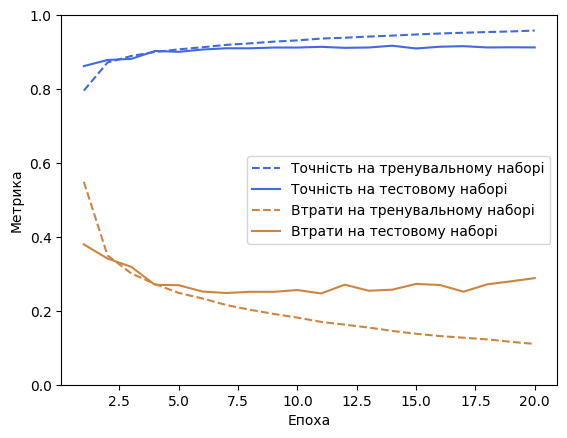

In [612]:
plt_history(history, optimal_parameters)

In [613]:
print_parameters(best_parameters, "Оптимальні параметри для model_2_1")
print(f" Точність:        {YELLOW}{test_acc}")

Оптимальні параметри для model_2_1
 epochs 	= 20
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']
 Точність:        0.9125999808311462


     Тренування моделі з двома callback

In [614]:
history = model.fit(
    train_images,
    train_labels,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(test_images, test_labels),
    # callbacks=[lr_scheduler_callback, early_stopping_callback, reduce_lr_callback],
    callbacks=[early_stopping_callback, reduce_lr_callback],
    # callbacks=[reduce_lr_callback],
    verbose=0,
)

In [615]:
print("          Точність:")
train_loss, train_acc = model.evaluate(train_images, train_labels)
print("          тренувальні дані: ", YELLOW, train_acc, RESET)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print("          тестові дані:     ", YELLOW, test_acc, RESET)

          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9862 - loss: 0.0430
          тренувальні дані:   0.9860333204269409 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9173 - loss: 0.3116
          тестові дані:       0.9199000000953674 


Поточні параметри:
 epochs 	= 20
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


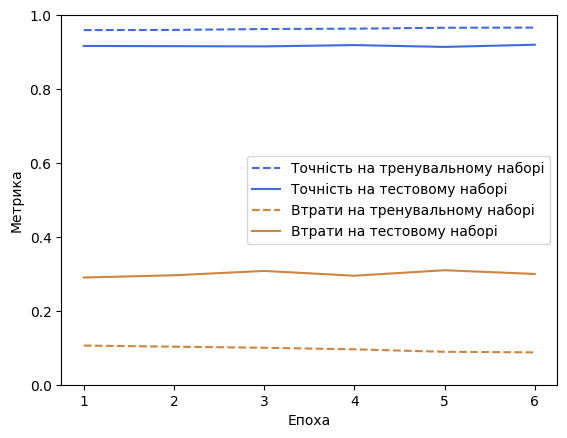

In [616]:
plt_history(history, optimal_parameters)

In [617]:
print_parameters(best_parameters, "Оптимальні параметри для model_2_1")
print(f" Точність:        {YELLOW}{test_acc}")

Оптимальні параметри для model_2_1
 epochs 	= 20
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']
 Точність:        0.9199000000953674


<div class="alert alert-block alert-info">
<b>Висновки:</b> 
<p>Додавання до навчання callback'у дозволило покращити роботу моделі<br>Точність сягнула <b>90.72%</p>
</div>

In [618]:
model.save("model.keras")

In [619]:
# # import matplotlib.pyplot as plt
# # import numpy as np

# # Передача вхідного зображення через модель та отримання feature maps для кожного шару
# activation_model = Model(
#     inputs=model.input, outputs=[layer.output for layer in model.layers]
# )
# activations = activation_model.predict(test_images[0].reshape(1, 28, 28, 1))

# # Візуалізація feature maps для кожного шару
# for layer_index, layer_activation in enumerate(activations):
#     if len(layer_activation.shape) == 4:  # Якщо це згортковий шар
#         num_features = layer_activation.shape[-1]
#         size = layer_activation.shape[1]

#         rows = num_features // 4  # Змінено з 8 на 4, оскільки менше фільтрів
#         cols = 4

#         plt.figure(figsize=(16, 2 * rows))
#         for i in range(num_features):
#             plt.subplot(rows, cols, i + 1)
#             plt.imshow(layer_activation[0, :, :, i], cmap="viridis")
#             plt.axis("off")
#         plt.suptitle(f"Layer {activation_model.layers[layer_index+1]} Feature Maps")
#         plt.show()